# HSBM exploration

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

from scipy.stats import entropy

In [2]:
with open('../models/13_7_2019_hsbm_analysis.p','rb') as infile:
    inputs = pickle.load(infile)

In [3]:
model,project_ids,mission_set_indices,mission_projs = [inputs[n] for n in [0,1,2,3]]

In [702]:
#model.plot(nedges=1000,filename='../reports/figures/presentation/topic_model.pdf')

model.plot(nedges=1000,filename='../../Mapping_Missions/figures/fig_5_topic_model.png')

In [62]:
def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)


def flatten_list(a_list):
    return([x for el in a_list for x in el])


In [10]:
#Extract projects in the active mission field
projects_mf = mission_projs[0]

In [13]:
# Step 1: create a df with a topic mix (level 1) per project id.

#Here we just loop over indices and names
tm = pd.concat([pd.DataFrame({e[0]:e[1] for e in model.topicdist(ind,l=1)},index=[name]) for ind,name in enumerate(project_ids)])

In [336]:
# Step 2: Lookup ids vs sets to create the topic mix

id_sets = [list(x['project_id']) for x in mission_projs]

id_sets[1],id_sets[2] = [[x for x in id_sets[val] if x not in id_sets[0]] for val in [1,2]]

In [337]:
# Step 3: Compare topics between groups: what's overrepresented in the active mission field and what isn't

tm_distributions= []

for ids in id_sets:
    
    #Topic mixes for projects in set

    tm_sel = tm.loc[ids]
    
    #Calculate topic means
    tm_means = tm_sel.mean()
    
    #Calculate projects with topic
    tm_presence = (tm_sel>0).sum()
    
    tm_distributions.append([tm_means,tm_presence])

In [338]:
tm_means,tm_presences = [pd.concat([x[n] for x in tm_distributions],axis=1) for n in [0,1]]

In [501]:
#We calculate relative specialisation in AI and Chronic diseases
spec_topics = create_lq_df(tm_presences[[1,2]].T).T

#Classify topics into categories depending on the component specialisation

allocation = {'ai':[],'cd':[],'shared':[]}

allocation['ai'] = list(spec_topics.loc[spec_topics[1]>1].sort_values(1,ascending=False).index)
allocation['cd'] = list(spec_topics.loc[spec_topics[2]>1].sort_values(2,ascending=False).index)


# for i,x in spec_topics.iterrows():
    
#     if x[1]>1:
#         allocation['ai'].append(i)
        
#     elif x[2]>1:
#         allocation['cd'].append(i)
        
#     else:
        
#         allocation['shared'].append(i)

In [502]:
#We need to import patches to create custom legends
import matplotlib.patches as mpatches

#This is for the legends
orange_patch = mpatches.Patch(color='orange', label='AI-related topic')
blue_patch = mpatches.Patch(color='blue', label='Chronic disease related \n topic')
#grey_patch = mpatches.Patch(color='lightgrey', label='Shared topic')

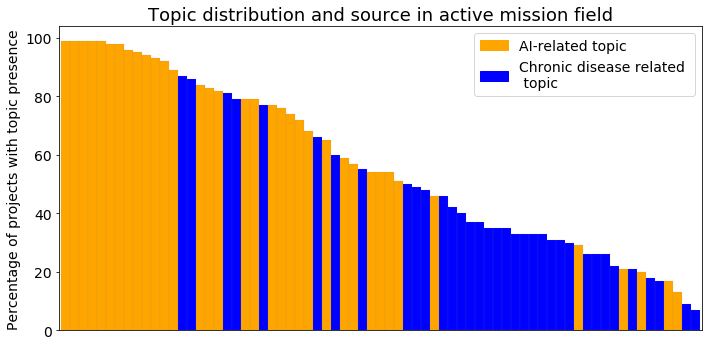

In [503]:
tm_sorted = tm_presences[0].sort_values(ascending=False)

fig,ax = plt.subplots(figsize=(10,5))

cols = ['orange' if ind in allocation['ai'] else 'blue' if ind in allocation['cd'] else 'lightgrey' for ind in tm_sorted.index]

tm_sorted.plot.bar(color=cols,width=1,edgecolor='grey',linewidth=0.1)

ax.legend(handles=[orange_patch,blue_patch,
                   #grey_patch
                  ],fontsize=14)

ax.yaxis.set_tick_params(labelsize=14)

ax.set_xticks([])

ax.set_ylabel('Percentage of projects with topic presence',fontsize=14)
ax.set_title('Topic distribution and source in active mission field',size=18)

plt.tight_layout()

plt.savefig('../../Mapping_Missions/figures/fig_18_distr.pdf')

In [568]:
# for n,x in enumerate(tm_sorted.index):
    
#     print(n)
    
#     print(model.topics(l=1)[x])
    
#     print('\n')

### Create a new topic mix

In [504]:
#In this topic mix df all topic mixes add to 1
tm_norm = tm.apply(lambda x: x/x.sum(),axis=1)

In [505]:
amf_indices = list(mission_projs[0]['project_id'])

In [506]:
tm_norm_short = tm_norm.loc[amf_indices]

### Visualise

In [507]:
#Indices for columns based on their category (AI, shared or chronic disease)
topic_indices = allocation['ai']+ allocation['cd']



In [569]:
#Sort them
tm_norm_short = tm_norm_short[topic_indices]

#Sort the indices to so we have projects with more prevalence of chronic disease topics in the left
sorted_indices = tm_norm_short[allocation['ai']].sum(axis=1).sort_values(ascending=False).index

#Subset
tm_norm_short = tm_norm_short.loc[sorted_indices]

#Create a colors df based on a topic's category
cols = ['orange' if ind in allocation['ai'] else 'blue' if ind in allocation['cd'] else 'lightgrey' for ind in tm_norm_short.columns]

#### Process the metadata for the second chart

In [570]:
#These are the projects in the active mission field
projects = mission_projs[0]

#Focus on year, funder and amount
meta = projects.set_index('project_id').loc[tm_norm_short.index][['year','funder','amount']]

#Get a color map
funder_map = plt.get_cmap('Accent')

funders_sorted = list(meta['funder'].value_counts().index)

#Create the color lookup
color_lookup = {f:c for f,c in zip(funders_sorted,funder_map.colors)}

#Add the color variable to the df
meta['color'] = meta['funder'].map(color_lookup)

#Create patches for the legend
funder_patches = [mpatches.Patch(color=c,label=l) for l,c in color_lookup.items()]

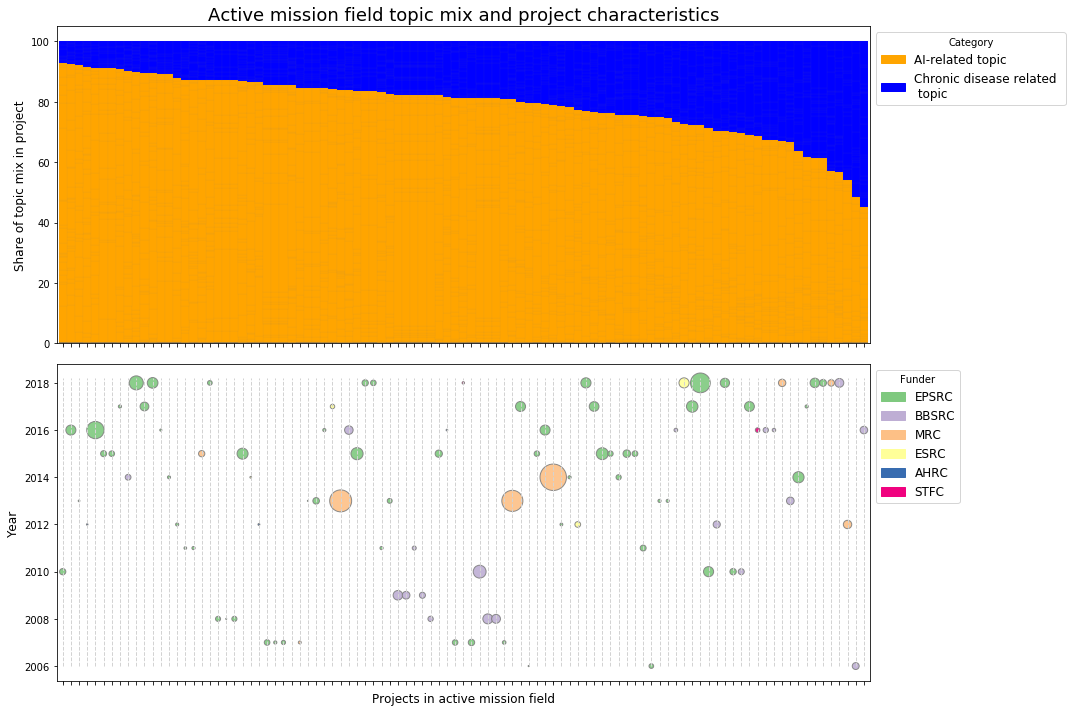

In [571]:
#Visualise
fig,ax = plt.subplots(figsize=(15,10),nrows=2,sharex=True)

#First the stacked barchart
(100*tm_norm_short).plot.bar(ax=ax[0],stacked=True,legend=False,color=cols,width=1,edgecolor='grey',linewidth=0.05)

#Its legend and axes
ax[0].legend(handles=[orange_patch,blue_patch,
                      #grey_patch
                     ],fontsize=12,bbox_to_anchor=(1,1),title='Category')

ax[0].set_xticklabels([])

ax[0].set_ylabel('Share of topic mix in project',size=12)

#Then the scatter
ax[1].scatter(np.arange(0,len(meta)),meta['year'],s=meta['amount']/10000,alpha=0.9,c=meta['color'],edgecolor='grey')

#Add vlines
ax[1].vlines(np.arange(0,len(meta)),ymin=2006,ymax=2018.2,color='lightgrey',linestyle='--',linewidth=1)

ax[1].set_ylabel('Year',size=12)

#Legends and axes
ax[1].set_xticklabels([])

ax[1].legend(handles=funder_patches,fontsize=12,bbox_to_anchor=(1,1),title='Funder')
ax[1].set_xlabel('Projects in active mission field',size=12)


ax[0].set_title('Active mission field topic mix and project characteristics',size=18)

plt.subplots_adjust(hspace=0.05)


plt.tight_layout()

plt.savefig('../../Mapping_Missions/figures/fig_19_proj_distr.pdf')



### Check evolution of activity over time

Here we want to look at the evolution of the distributio of topics over time

In [511]:
#We focus on the active mission field

amf = projects

#This extracts the number of projects with the topic in the year
# year_topics = pd.concat([
#     (tm.loc[list(amf.loc[amf['year']==y]['project_id'])]>0).sum() for y in np.arange(2006,2019)],axis=1)

year_topics = pd.concat([
    tm.loc[list(amf.loc[amf['year']==y]['project_id'])].sum() for y in np.arange(2006,2019)],axis=1)



year_topics.columns= np.arange(2006,2019)

In [512]:
#Here we sort IDs by category (AI, chronic disease etc) and by totals. 
sorted_ids = flatten_list([list(year_topics.loc[allocation[v]].sum(axis=1).sort_values(ascending=False).index) for v in ['ai','cd','shared']])

year_topics = year_topics.loc[sorted_ids]

In [513]:
year_topics_2 = pd.concat([
    (tm.loc[list(amf.loc[amf['year']==y]['project_id'])]>0).sum() for y in np.arange(2006,2019)],axis=1)
year_topics_2.columns= np.arange(2006,2019)

entropy_series= pd.concat(
    [year_topics_2.loc[allocation[var]].apply(lambda x: x/x.sum(),axis=0).apply(lambda x: entropy(x)) for var in ['cd','ai']],axis=1)

entropy_series.columns = ['chronic disease related topics','AI-related topics']


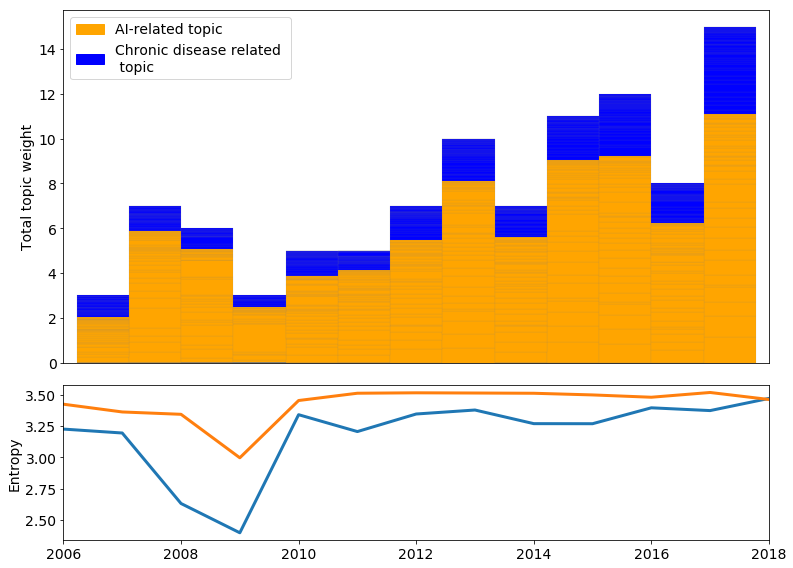

In [601]:
fig,ax = plt.subplots(figsize=(11,8),nrows=2,sharex=False,gridspec_kw={'height_ratios': [4, 1.75]})

cols_2 = ['orange' if ind in allocation['ai'] else 'blue' if ind in allocation['cd'] else 'lightgrey' for ind in year_topics.index]

year_topics.T.plot.bar(stacked=True,legend=False,ax=ax[0],color=cols_2,edgecolor='grey',linewidth=0.1,width=1)

ax[0].set_ylabel('Total topic weight',fontsize=14)
ax[0].yaxis.set_tick_params(labelsize=14)
ax[0].xaxis.set_tick_params(labelsize=14)

ax[0].legend(handles=[orange_patch,blue_patch,
                      #grey_patch
                     ],fontsize=14)
#ax[0].set_title('Topic mass and entropy',size=18)
ax[0].set_xticks([])

entropy_series.plot(ax=ax[1],linewidth=3,legend=False)

ax[1].yaxis.set_tick_params(labelsize=14)
ax[1].xaxis.set_tick_params(labelsize=14)
ax[1].set_ylabel('Entropy',fontsize=14)

plt.tight_layout()

plt.savefig('../../Mapping_Missions/figures/fig_20_topic_trends.pdf')


### Health issue trends

In [604]:
tm_norm_short_2 = pd.concat([tm_norm_short,meta[['year','funder']]],axis=1)

In [698]:
cd_topic_counts = pd.concat([pd.crosstab(tm_norm_short_2['year'],tm_norm_short_2[n]>0).iloc[:,1] for n in list(allocation['cd'])],axis=1)
cd_topic_counts.columns = list(allocation['cd'])

In [699]:
cd_topic_counts.columns = [re.sub('\n','',' '.join([x[0] for x in model.topics(l=1)[v]])[:60]) for v in cd_topic_counts.columns]

cd_index = cd_topic_counts.loc[2018].sort_values(ascending=False).index



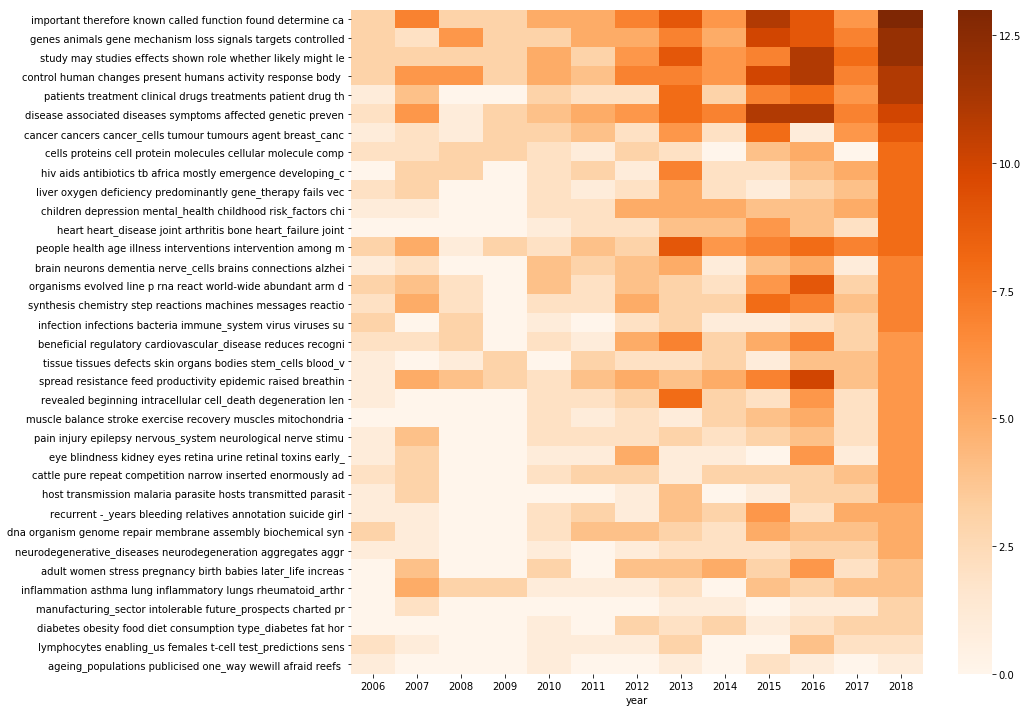

In [701]:
import seaborn as sns

ax = plt.subplots(figsize=(15,10))

sns.heatmap(cd_topic_counts.T.loc[cd_index],cmap='Oranges')

plt.tight_layout()

plt.savefig('../../Mapping_Missions/figures/fig_21_heatmap.pdf')

In [529]:
# Topic table

In [530]:
topics = model.topics(l=1)

#sorted_indices = flatten_list([list(tm[allocation[var]].sum().sort_values(ascending=False).index) for var in ['ai','cd','shared']])

In [549]:
topics_df = pd.DataFrame([{'keywords':' '.join([x[0] for x in kws[:6]]),'allocation':'AI' if n in allocation['ai'] else 'Chronic' if n in
                         allocation['cd'] else 'Shared'} for n,kws in topics.items()])

topics_df = topics_df.sort_values('allocation',ascending=True).loc[topic_indices]

In [555]:
three_cols = pd.concat([topics_df.loc[topics_df['allocation']==v].reset_index(drop=True) for v in ['AI','Chronic','Shared']]
                                                                                                      ,axis=1).fillna('')

In [558]:
topics_df.to_latex('../../Mapping_Missions/table.tex',col_space=1000)

In [559]:
three_cols

,allocation,keywords,allocation,keywords,allocation,keywords
0,AI,team informed algorithm accounts constraints g...,Chronic,inflammation asthma lung inflammatory lungs rh...,,
1,AI,choices acquisition robotics remote reading pr...,Chronic,cells proteins cell protein molecules cellular,,
2,AI,language translation words sound noise hearing,Chronic,patients treatment clinical drugs treatments p...,,
3,AI,applications network software computer_science...,Chronic,diabetes obesity food diet consumption type_di...,,
4,AI,amp security london literature perspective cul...,Chronic,infection infections bacteria immune_system vi...,,
5,AI,scientific modern challenging dynamics paralle...,Chronic,adult women stress pregnancy birth babies,,
6,AI,challenge energy integrated building evaluatio...,Chronic,tissue tissues defects skin organs bodies,,
7,AI,ethical_legal minimally predisposing ensure_sa...,Chronic,cancer cancers cancer_cells tumour tumours agent,,
8,AI,systems technology technologies performance mo...,Chronic,disease associated diseases symptoms affected ...,,
9,AI,design enable designed industry products platform,Chronic,hiv aids antibiotics tb africa mostly,,


In [535]:
three_cols = three_cols.iloc[:,[1,3]]
three_cols.columns = ['AI','Chronic']

In [536]:
three_cols.to_latex('../../Mapping_Missions/topic_table.tex',index=False)

In [686]:
# for n,x in projects_mf.loc[
#     #(projects_mf.year==2018) & 
#     (projects_mf.funder=='AHRC')].sort_values('amount').iterrows():
       
#     print(x['amount']/1e6)
#     print(x['title'])
    
#     print('\n')
    
#     print(str(x['abstract'])[:10000])
    
#     print('\n')

0.023999
Translation Arrays: Version Variation Visualization (Phase 2)


Shakespeare is celebrated as &quot;the world's playwright&quot; at the 2012 Cultural Olympiad. His works have been and still are being translated into scores of languages. In many languages, they have been translated over and over again, scores of times. Translations vary in kind, from philologically precise study aids to free 'adaptations' or 'versions'. All are interpretations, displaying variation in language, concepts and values. Together, they are a very rich mine of information about world cultural variation and change, past and present. 

Translations, being comparable, lend themselves to computational analysis. Digital media make it possible to bring together very large numbers of translations and explore how and where they differ. Data visualization tools make it possible to survey them and navigate easily through them, even without knowing the languages involved. Statistical analyses of variation among t

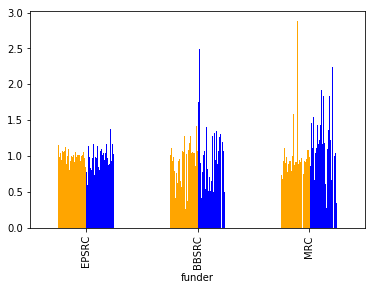

In [689]:
funder_focus = tm_norm_short_2.groupby('funder')[topic_indices].apply(lambda x: x.applymap(lambda y: y>0).sum())


funder_focus_norm = create_lq_df(funder_focus)


funder_focus_norm.loc[['EPSRC','BBSRC','MRC'],:].plot.bar(legend=False,color=cols)

In [648]:
#sns.heatmap(funder_focus,cmap='viridis')

In [683]:
funder_focus.max(axis=1)

funder
AHRC      3
BBSRC    19
EPSRC    62
ESRC      4
MRC       9
STFC      2
dtype: int64

In [717]:
with open('/Users/jmateosgarcia/Desktop/ai_analysis/ai_analysis/data/external/ai_ids.p','wb') as outfile:
    pickle.dump(set(mission_projs[1]['project_id']),outfile)